## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

pd.set_option('display.max_columns', None)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57720,00014302_004.png,No Finding,4,14302,41,M,PA,2642,2789,0.143,0.143,NaN,/data/images_007/images/00014302_004.png
93949,00023764_000.png,No Finding,0,23764,50,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00023764_000.png
16680,00004470_001.png,No Finding,1,4470,37,F,PA,2048,2500,0.168,0.168,NaN,/data/images_003/images/00004470_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000013_010.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000032_012.png,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000056_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_012.png,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_015.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030536_007.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030570_001.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030621_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030637_016.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    #return train_data, val_data
    train_data, val_data=skl.train_test_split(vargs,
                                              test_size=0.2,
                                             stratify=vargs['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

In [7]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1145
False    1145
Name: pneumonia_class, dtype: int64

In [8]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

In [9]:
#check train_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=-0.13232852112051666, pvalue=0.8947421027066789)

In [10]:
#check train_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=-0.6664217926091902, pvalue=0.505286006572281)

In [11]:
train_data['Patient Gender'].value_counts()

M    1335
F     955
Name: Patient Gender, dtype: int64

In [12]:
#check val_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     val_data['Patient Age'][(val_data['Pneumonia']== True) & (val_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=0.26764942125193386, pvalue=0.7890242680982306)

In [13]:
#check val_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
                     val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=1.5994383980228046, pvalue=0.11016746881650054)

In [14]:
val_data['Patient Gender'].value_counts()

M    790
F    640
Name: Patient Gender, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             ) 
    
    return val_gen

In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


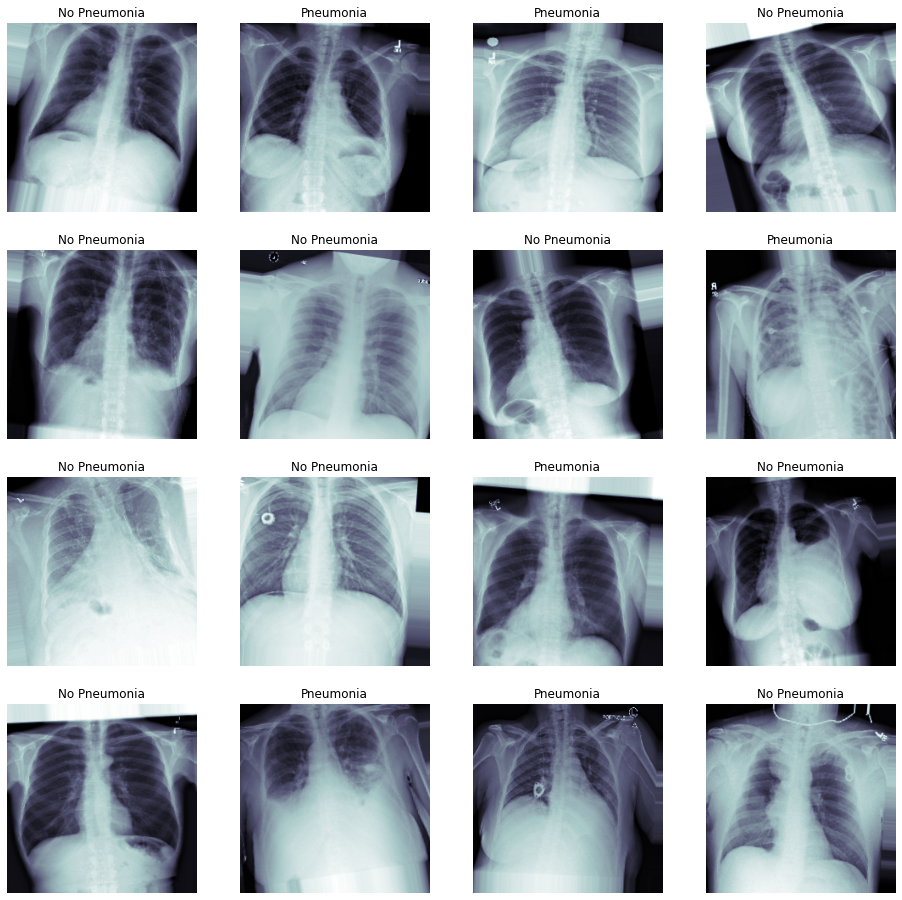

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_idg = my_image_augmentation() # train
train_gen = make_train_gen(train_idg, train_data)


t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model(layer_of_interest):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [19]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
#    my_model_history = my_model.fit_generator(train_gen, 
#                                             validation_data=(val_X, val_Y),
#                                             epochs=epochs)
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',  # CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto',  # CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                             save_weights_only = True)


early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)
# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [21]:
## train your model

# Todo

vgg_model = load_pretrained_model('block5_pool')
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 45 steps
Epoch 1/10
143/144 [============================>.] - ETA: 14s - loss: 0.7914 - binary_accuracy: 0.5330
Epoch 00001: val_loss improved from inf to 0.70037, saving model to xray_class_my_model.best.hdf5
144/144 [==============================] - 3341s 23s/step - loss: 0.7911 - binary_accuracy: 0.5323 - val_loss: 0.7004 - val_binary_accuracy: 0.5378
Epoch 2/10
  5/144 [>.............................] - ETA: 34:39 - loss: 0.6683 - binary_accuracy: 0.6250WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
    # https://knowledge.udacity.com/questions/338645
    # Todo
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    metrics.auc(fpr, tpr)
    
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    #ax.title('model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    return

In [ ]:
plot_auc(valY,pred_Y)

In [ ]:
plot_history(history)

In [ ]:
## plot figures

# Todo

def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('out/Model_Training_Performance')
    plt.show()

    return

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
predicted_Y = [ 1 if x > 0.4 else 0 for x in pred_Y]

In [ ]:
predicted_Y = [ 1 if x > 0.4 else 0 for x in pred_Y]
precision = precision_score(valY, predicted_Y)
print("Threshold of 0.4 is ",precision)

In [ ]:
from sklearn.metrics import f1_score
predicted_Y = [ 1 if x > 0.53 else 0 for x in pred_Y]
f1score = f1_score(valY, predicted_Y, average='weighted')
print(f1score)

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
optimal_model_threshold = 0.53
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX_newset[0:100], valY_newset[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y_newset[i] > optimal_model_threshold:
            c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y_newset[i] > optimal_model_threshold: 
                 c_ax.set_title('0, 1')
        else:
                 c_ax.set_title('0, 0')
        c_ax.axis('off')
        i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
print(model_json)
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)